In [7]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Input, Concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow import lite

In [2]:
data_dir = r'C:\Users\yashu\Downloads\Desktop\final year project\data\train'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
filepaths_series = pd.Series(filepaths, name='filepaths')
labels_series = pd.Series(labels, name='labels')
df = pd.concat([filepaths_series, labels_series], axis=1)
df

,filepaths,labels
0,C:\Users\yashu\Downloads\Desktop\final year pr...,close eyes
1,C:\Users\yashu\Downloads\Desktop\final year pr...,close eyes
2,C:\Users\yashu\Downloads\Desktop\final year pr...,close eyes
3,C:\Users\yashu\Downloads\Desktop\final year pr...,close eyes
4,C:\Users\yashu\Downloads\Desktop\final year pr...,close eyes
...,...,...
81670,C:\Users\yashu\Downloads\Desktop\final year pr...,open eyes
81671,C:\Users\yashu\Downloads\Desktop\final year pr...,open eyes
81672,C:\Users\yashu\Downloads\Desktop\final year pr...,open eyes
81673,C:\Users\yashu\Downloads\Desktop\final year pr...,open eyes


In [3]:
train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

In [4]:
test_data_dir = r'C:\Users\yashu\Downloads\Desktop\final year project\data\test'
test_filepaths = []
test_labels = []
test_folds = os.listdir(test_data_dir)
for test_fold in test_folds:
    test_foldpath = os.path.join(test_data_dir, test_fold)
    test_filelist = os.listdir(test_foldpath)
    for test_file in test_filelist:
        test_fpath = os.path.join(test_foldpath, test_file)
        test_filepaths.append(test_fpath)
        test_labels.append(test_fold)
test_filepaths_series = pd.Series(test_filepaths, name='filepaths')
test_labels_series = pd.Series(test_labels, name='labels')
test_df = pd.concat([test_filepaths_series, test_labels_series], axis=1)


In [5]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
def scalar(img):
    return img
tr_gen = ImageDataGenerator(preprocessing_function=scalar)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=test_batch_size)


Found 65340 validated image filenames belonging to 2 classes.
Found 16335 validated image filenames belonging to 2 classes.
Found 3223 validated image filenames belonging to 2 classes.


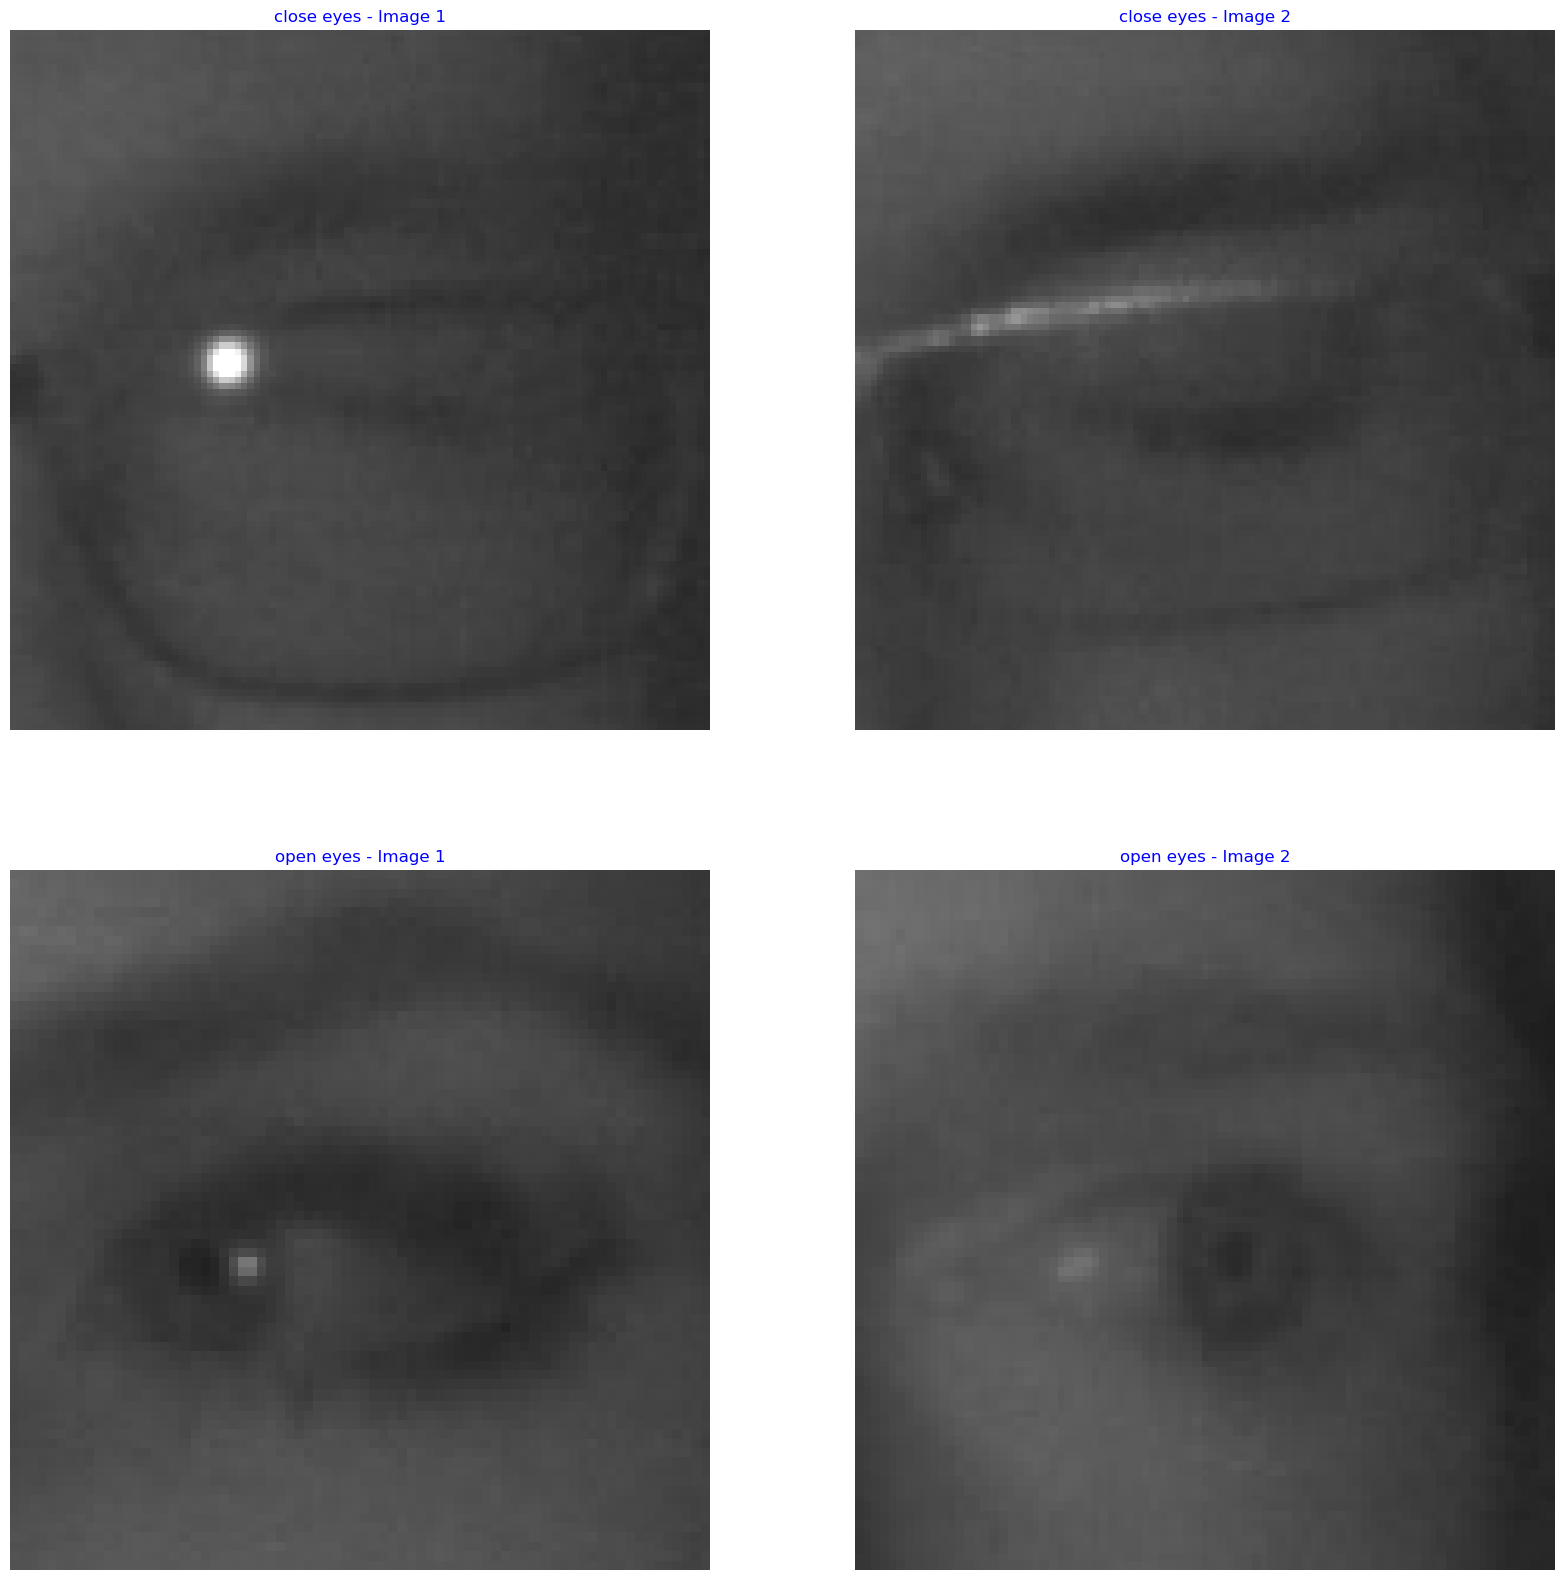

In [6]:
unique_dict = train_gen.class_indices  
unique_classes = list(unique_dict.keys())  
unique_class_images = {class_name: [] for class_name in unique_classes}
for i in range(2):
    unique_images, unique_labels = next(train_gen)
    for j in range(len(unique_labels)):
        index = np.argmax(unique_labels[j]) 
        class_name = unique_classes[index] 
        if len(unique_class_images[class_name]) < 2:
            unique_class_images[class_name].append(unique_images[j] / 255) 
plt.figure(figsize=(20, 20))
for i, class_name in enumerate(unique_classes):
    for j in range(2):
        plt.subplot(len(unique_classes), 2, i * 2 + j + 1)
        plt.imshow(unique_class_images[class_name][j])
        plt.title(f'{class_name} - Image {j + 1}', color='blue', fontsize=12)
        plt.axis('off')

plt.show()


## model for close and open eye


customized efficientnet

In [10]:
def efficientnet_block(x, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  # Changed activation function to ReLU
    return x

def efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9):
    input_tensor = Input(shape=input_shape)
    x = efficientnet_block(input_tensor, filters=32, kernel_size=(3, 3), strides=2)
    num_blocks = [1, 2, 2, 3]  
    filters = [16, 24, 40, 80]  
    for i, (blocks, filters) in enumerate(zip(num_blocks, filters)):
        for j in range(blocks):
            strides = 2 if j == 0 and i != 0 else 1
            x = efficientnet_block(x, filters=filters, kernel_size=(3, 3), strides=strides)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x) 
    model = tf.keras.Model(inputs=input_tensor, outputs=x, name='efficientnet_model')
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = img_shape  
num_classes = len(set(labels))
model = efficientnet_model(input_shape, num_classes, learning_rate=0.001, momentum=0.9)
checkpoint_path = "efficientnet_custom_c_n_model_RELU.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#epoch_checkpoint = ModelCheckpoint("efficientnet_epoch_{epoch:02d}_MRL.h5", save_freq='epoch', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch))
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    epochs=15,
    initial_epoch=0,
    callbacks=[early_stopping, model_checkpoint, epoch_checkpoint, reduce_lr, lr_schedule],
    verbose=1
)
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
best_model = tf.keras.models.load_model(checkpoint_path)

Epoch 1/15
4084/4084 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5621
Epoch 1: val_accuracy improved from -inf to 0.87983, saving model to efficientnet_custom_c_n_model_RELU.h5

Epoch 1: saving model to efficientnet_epoch_01_MRL.h5


C:\Users\yashu\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4084/4084 [==============================] - 1231s 300ms/step - loss: nan - accuracy: 0.5621 - val_loss: 0.3202 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 2/15
4084/4084 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6099
Epoch 2: val_accuracy did not improve from 0.87983

Epoch 2: saving model to efficientnet_epoch_02_MRL.h5
4084/4084 [==============================] - 1238s 303ms/step - loss: nan - accuracy: 0.6099 - val_loss: 0.5397 - val_accuracy: 0.7670 - lr: 9.0000e-04
Epoch 3/15
4084/4084 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6126
Epoch 3: val_accuracy did not improve from 0.87983

Epoch 3: saving model to efficientnet_epoch_03_MRL.h5
4084/4084 [==============================] - 1074s 263ms/step - loss: nan - accuracy: 0.6126 - val_loss: 0.5695 - val_accuracy: 0.6952 - lr: 8.1000e-04
Epoch 4/15
4084/4084 [==============================] - ETA: 0s - loss: nan - accuracy: 0.6156
Epoch 4: val_accuracy improved from 0.87983 to 0.93

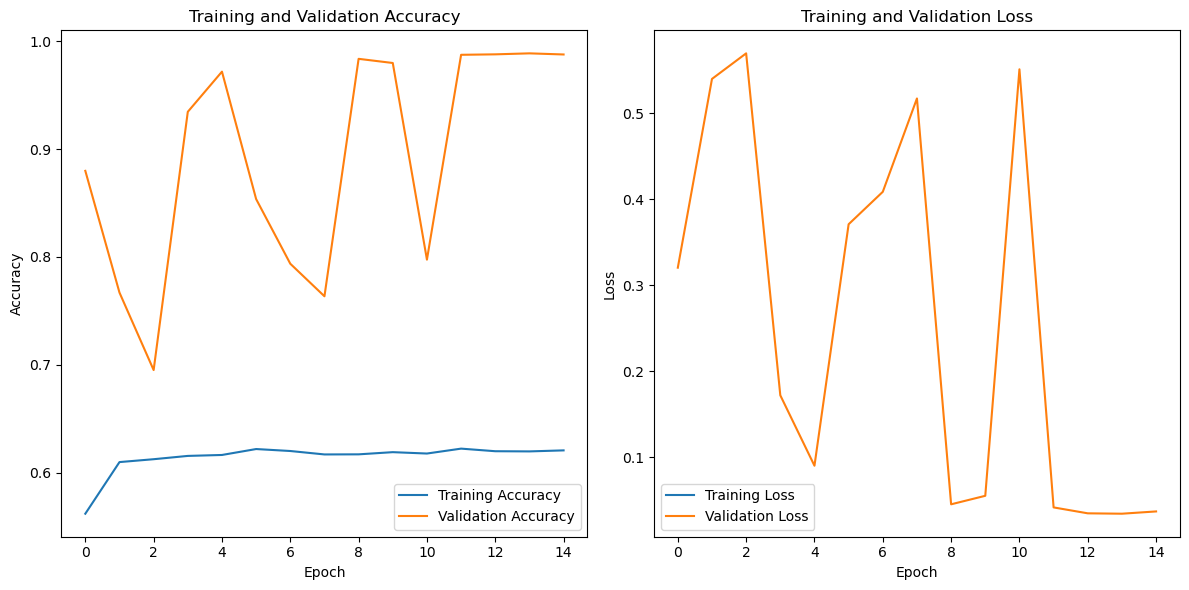

In [11]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
test_loss, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
val_loss, val_accuracy = model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

293/293 [==============================] - 17s 56ms/step - loss: 0.0988 - accuracy: 0.9690

Test Loss: 0.0988
Test Accuracy: 96.90%
1021/1021 [==============================] - 81s 79ms/step - loss: 0.0368 - accuracy: 0.9877

Validation Loss: 0.0368
Validation Accuracy: 98.77%


293/293 [==============================] - 17s 56ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1566
           1       1.00      0.94      0.97      1657

    accuracy                           0.97      3223
   macro avg       0.97      0.97      0.97      3223
weighted avg       0.97      0.97      0.97      3223



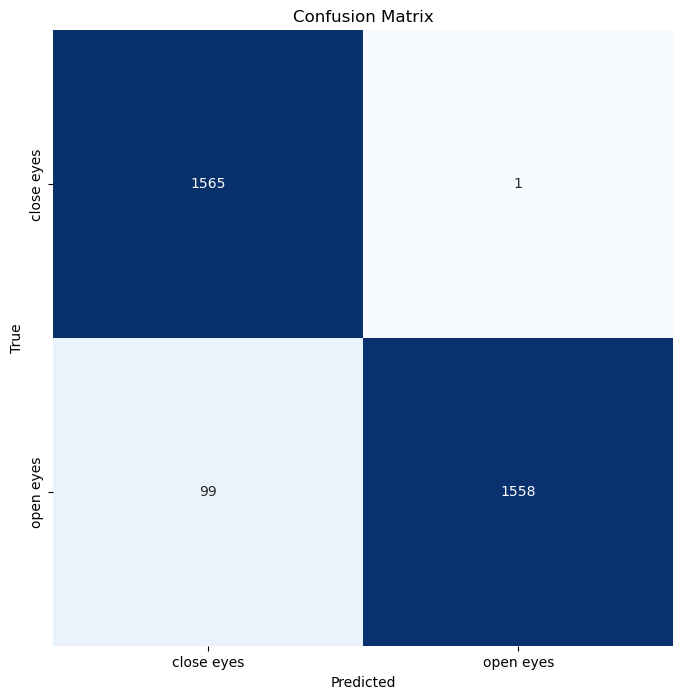

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_gen, steps=test_steps, verbose=1)
if isinstance(test_gen.labels, list):
    y_true = np.array(test_gen.labels)
else:
    y_true = test_gen.labels
if len(y_true.shape) > 1:
    y_true = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9708
Recall: 0.9690
